In [95]:
import tensorflow as tf

## load image
from PIL import Image 
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from tensorflow.keras import datasets, layers, models


Data Source: https://www.kaggle.com/brsdincer/vehicle-detection-image-set/code

# Load Data

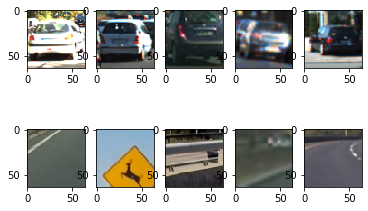

In [15]:
## view some image
vehicle_folder=r'data/vehicles/'
nonvehicle_folder = r'data/non-vehicles'
for i in range(5):
    file1 = random.choice(os.listdir(vehicle_folder))
    file2 = random.choice(os.listdir(nonvehicle_folder))
    image1_path = os.path.join(vehicle_folder, file1)
    image2_path = os.path.join(nonvehicle_folder, file2)
    img1=mpimg.imread(image1_path)
    ax=plt.subplot(2,5,i+1)
    plt.imshow(img1)
    img2=mpimg.imread(image2_path)
    ax=plt.subplot(2,5,5+i+1)
    plt.imshow(img2)
    
## first row: vehicle/ second row: non-vehicle

In [7]:
## load image

def create_dataset_PIL(img_folder):   
    img_data_array=[]
    class_name=[]
    for dir1 in os.listdir(img_folder):
        if dir1=='.DS_Store':
            continue
        for file in os.listdir(os.path.join(img_folder, dir1)):     
            image_path= os.path.join(img_folder, dir1,  file)
            image= np.array(Image.open(image_path))
            # transform to float
            image = image.astype('float32')
            # normalize
            image /= 255  
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array , class_name

PIL_img_data, class_name=create_dataset_PIL(img_folder)

In [9]:
## this is 64*64 image
PIL_img_data[0].shape

(64, 64, 3)

In [25]:
## now we are having list of arrary, classname is still string
print(type(PIL_img_data))
print(type(PIL_img_data[0]))
print(class_name[0])

<class 'list'>
<class 'numpy.ndarray'>
non-vehicles


In [26]:
## convert string to int
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_dict

{'non-vehicles': 0, 'vehicles': 1}

In [29]:
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]
type(target_val[0])

int

In [109]:
## split to test and train
import sklearn.model_selection as sk
X_train, X_test, y_train, y_test = sk.train_test_split(np.array(PIL_img_data),target_val,\
                                                       test_size=0.33, random_state = 42)

In [110]:
X_train_tf = tf.cast(X_train, tf.float64)
X_test_tf = tf.cast(X_test, tf.float64)
y_train_tf = tf.cast(y_train, tf.int32)
y_test_tf = tf.cast(y_test, tf.int32)

In [84]:
## now x and y are tensor
print(X_train.shape)
print(type(X_train))

(11899, 64, 64, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>


# Two layer CNN

In [55]:
model=tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(64,64, 3)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation="sigmoid")
        ])
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

In [58]:
history = model.fit(X_train_tf, y_train_tf, epochs=4)

Epoch 1/4
372/372 [==============================] - 20s 54ms/step - loss: 0.0410 - accuracy: 0.9857
Epoch 2/4
372/372 [==============================] - 11s 31ms/step - loss: 0.0331 - accuracy: 0.9888
Epoch 3/4
372/372 [==============================] - 12s 33ms/step - loss: 0.0311 - accuracy: 0.9906
Epoch 4/4
372/372 [==============================] - 11s 29ms/step - loss: 0.0251 - accuracy: 0.9914


In [59]:
test_loss, test_acc = model.evaluate(X_test_tf, y_test_tf, verbose=2)
print(test_acc)

184/184 - 2s - loss: 0.0280 - accuracy: 0.9906
0.990615963935852


In [61]:
y_predict = model.predict(X_test_tf)

In [67]:
print((y_predict[0],y_test[0]))

(array([0.9998112], dtype=float32), 1)


In [70]:
model.save(r"model/simple_2conv_layer_model.h5")

# Transformer

In [ ]:
!pip install -U tensorflow-addons

In [89]:
import tensorflow_addons as tfa
from tensorflow import keras

In [111]:
num_classes = 2
input_shape = (64, 64, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] # Size of the dense layers of the final classifier 

In [112]:
# data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train_tf)

In [113]:
# multilayer perceptron
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [114]:
# patch creation
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


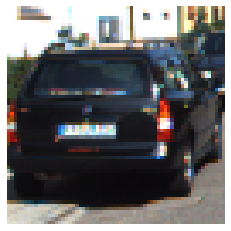

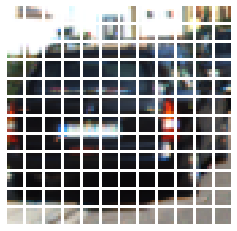

In [115]:
# visualize patch
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img)
    plt.axis("off")

In [116]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        # embedding each patch by projecting to a vector
        self.projection = layers.Dense(units=projection_dim)
        # encoding position
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        # position from 0-#patches
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # add patch projected vector and positional encoding
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [121]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1, activation="sigmoid")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [124]:
def run_experiment(model):
    optimizer = 'adam'

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="binary_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train_tf,
        y=y_train_tf,
        batch_size=batch_size,
        epochs=4,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test_tf, y_test_tf)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/4
42/42 [==============================] - 1250s 29s/step - loss: 0.8631 - binary_accuracy: 0.8151 - val_loss: 0.1822 - val_binary_accuracy: 0.9387
Epoch 2/4
42/42 [==============================] - 1349s 32s/step - loss: 0.1582 - binary_accuracy: 0.9392 - val_loss: 0.1535 - val_binary_accuracy: 0.9328
Epoch 3/4
42/42 [==============================] - 2024s 49s/step - loss: 0.0996 - binary_accuracy: 0.9641 - val_loss: 0.0528 - val_binary_accuracy: 0.9807
Epoch 4/4
184/184 [==============================] - 136s 739ms/step - loss: 0.0415 - binary_accuracy: 0.9834
Test accuracy: 98.34%


# CNN with Residual Connection

In [145]:
def residual_connection(input_shape, 
                        num_filters=16,
                        kernel_size=3,
                        strides=1):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    for i in range(2):
        x = layers.Conv2D(num_filters,kernel_size=kernel_size,strides=(strides,strides),padding='same')(x)
        x = layers.BatchNormalization(axis = 3)(x)
        x = layers.Activation('relu')(x)
    x = layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=(strides,strides), padding = 'same')(x)
    x = layers.BatchNormalization(axis = 3)(x)
    ## linear projection residual shortcut connection to match changed dims
    y = layers.Conv2D(num_filters,kernel_size=1,strides=(1,1))(inputs)
    y = layers.Add()([x, y])
    y = layers.Activation('relu')(y)
    y = layers.Flatten()(y)
    outputs = layers.Dense(1,activation="sigmoid")(y)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = residual_connection(input_shape = (64,64,3))
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

history = model.fit(X_train_tf, y_train_tf, epochs=4)

Epoch 1/4
372/372 [==============================] - 118s 314ms/step - loss: 0.2437 - accuracy: 0.9316
Epoch 2/4
372/372 [==============================] - 126s 338ms/step - loss: 0.0722 - accuracy: 0.9782
Epoch 3/4
372/372 [==============================] - 127s 342ms/step - loss: 0.0442 - accuracy: 0.9858
Epoch 4/4
372/372 [==============================] - 129s 346ms/step - loss: 0.0460 - accuracy: 0.9860


In [146]:
test_loss, test_acc = model.evaluate(X_test_tf, y_test_tf, verbose=2)
print(test_acc)

184/184 - 14s - loss: 0.1036 - accuracy: 0.9766
0.9766251444816589


# Conclusion

- a simple CNN seems to perform the best, also the fastest. Vision Transformer runs really slow. Maybe I should use less patches or drop the augmentation step.
- CNN with residual connection doesn't perform so well, maybe it's because I didn't implement ResNet, just two layer CNN. Residual connection are designed to solve the overfitting problem, this case might even be underfitting.
- This is a simple binary classification problem, so I am not surprised that all three methods achieve high accuracy. It will be interesting to try a more complicated problem in the future. 